In [81]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg

import torch 
import torch.nn as nn
import torchvision

import pretrainedmodels
import pretrainedmodels.utils

import ssl 
# Disable SSL certificate verification
ssl._create_default_https_context = ssl._create_unverified_context

# Since we don't have CPU
map_location=torch.device('cpu')

# Load the model 

In [82]:
class PretrainedResnetApparealDS():
    """
        This class loads the model architecture with the specific weights computed during 
        the training for the age estimation task.
        
        Parmeters : 
            - weights_path (str) : the path to the object .pth containing the weights of the trained model 
            - model_name (str) : the name of the pretrained model from which we get the architecture of our model
            - num_classes (int) : the number of classes of the classifictaion task
            - pretrained (str) : specifies to only retrieve the architecture of the pretained model
            - model (obj) : the model with the correct architecture and weights that we will use
    """ 
    
    def __init__(self, weights_path = 'weights_finetuned.pth'): 
        self.weights_path = weights_path
        self.model_name = "se_resnext50_32x4d"
        self.num_classes = 101
        self.pretrained = None
        self.model = self.apply_finetuned_weights_to_model()
        
    def get_model_architecture(self):
        """ 
            Loads the architecture of the original pretrained model.
        """
        model = pretrainedmodels.__dict__[self.model_name](pretrained=self.pretrained)
        dim_feats = model.last_linear.in_features
        model.last_linear = nn.Linear(dim_feats, self.num_classes)
        model.avg_pool = nn.AdaptiveAvgPool2d(1)
        return  model 

    def load_finetuned_weights(self):
        """
            Load the weights of the model fine tuned during the training (done on Onixya).
        """
        return torch.load(self.weights_path, map_location="cpu")
    
    def apply_finetuned_weights_to_model(self):
        """ 
            Applies the weights to the architecture of the initial model and return the final model.
        """
        model = self.get_model_architecture()
        weights = self.load_finetuned_weights()
        model.load_state_dict(weights['state_dict'])
        return model 

In [83]:
# Intanciate a class and retrived the model with the lattest fine tunned weights for the avg
pretrained_resnest_appareal_ds = PretrainedResnetApparealDS()
model = pretrained_resnest_appareal_ds.model

# Exploration
## 1. Pass an image to the model 

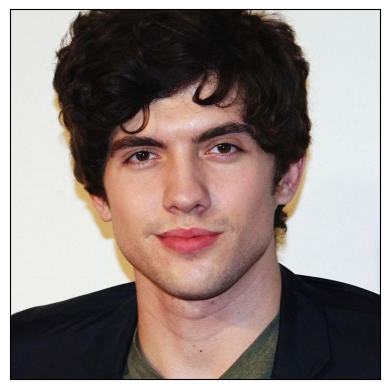

In [84]:
# Import a picture
image_test = mpimg.imread("appa-real-release/test/005616.jpg_face.jpg")
plt.imshow(image_test)
plt.xticks([])
plt.yticks([])
plt.show()

In [85]:
# Transfom the picture into a tensor
image_test_tensor = torch.from_numpy(image_test)
image_test_tensor = torch.permute(image_test_tensor, (2,0,1))
image_test_tensor = image_test_tensor.unsqueeze(0)
image_test_tensor = image_test_tensor.type(torch.float32)

In [86]:
# The model predict that the person is 28 years old
model(image_test_tensor).argmax()

tensor(28)

## 2. Compute an attack from an image and apply it

In [87]:
class ImageAttacked():
    """ 
        This class computes the attack on a specific image of a specific model, stores this attack and applies it 
        to any given image. 
        The goal is to see if an attack computed on an image can have an effective impact on another image.
        
        Parameters : 
            - model (object) : the pretrained model that will be attacked 
            - epsilon (float) : the  maximum pixel perturbation allowed
            - attack (tensor) : the tensor correspondong to the attack computed (i.e. an image)
            - attack_done (bool) : True if an attack was already computed
    """
    def __init__(self, model, epsilon : float):
        self.model = model 
        self.espsilon = epsilon
        self.attack = None
        self.attack_done = False
    
    def get_image(self, datatset : str, image_file_name : str) :
        """ 
                This function returns the image converted into a tensor. 
                
                Parameters : 
                    - datatset (string) : specifies the dateset of the image (e.g. train, valid or test)
                    - image_file_name (string) : file name of the image
        """
        # Load the image 
        image = mpimg.imread(f"appa-real-release/{datatset}/{image_file_name}")
        
        # Transfom the picture into a tensor
        image_tensor = torch.from_numpy(image)
        image_tensor = torch.permute(image_tensor, (2,0,1))
        image_tensor = image_tensor.unsqueeze(0)
        image_tensor = image_tensor.type(torch.float32)
        
        return image_tensor
        
    def get_image_real_age(self, datatset : str, image_file_name : str) : 
        """ 
                This function returns the real age of a person from a specific image. 
                
                Parameters : 
                    - datatset (string) : specifies the dateset of the image (e.g. train, valid or test)
                    - image_file_name (string) : file name of the image
        """
        df = pd.read_csv(f"appa-real-release/gt_avg_{datatset}.csv")

        if "face" in image_file_name : 
                # Retrive the correct file name 
                image_file_name = image_file_name.split("_")[0]
            
        return df[df.file_name == image_file_name].real_age.values[0]

    def compute_attack(self,  datatset : str, image_file_name : str) : 
        """ 
                This function computes the attack on a specific image and store the attack in self.attack.
                It returns the attack (tensor).
                
                Parameters : 
                    - datatset (string) : specifies the dateset of the image (e.g. train, valid or test)
                    - image_file_name (string) : file name of the image
        """     

        # Get the image converted into a tensor 
        image_tensor = self.get_image(datatset, image_file_name)
        
        # Get the real age of the image (type : integer)
        real_age = self.get_image_real_age(datatset, image_file_name).item()

        # Create a copy of the original image to attack it and keep the original one for comparaison
        attacked_img_tensor = image_tensor.detach().clone()

        # Enable the grandient computation on the image itself
        attacked_img_tensor.requires_grad = True

        # Get the probability for each of the 101 classes computed by the model 
        output = self.model(attacked_img_tensor)

        # Compute the cross entropy loss
        loss = - torch.nn.functional.cross_entropy(output, torch.LongTensor([real_age]))

        self.model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect gradient of the image
        grad = attacked_img_tensor.grad.data

        # Compute the attack (same shape as the original image) and store it
        self.attack = self.espsilon * grad.sign()
        self.attack_done = True

        return self.attack
        
        
            
    def apply_attack_to_image(self,  datatset : str, image_file_name : str, show = False): 
        """ 
                This function applies the attack (previously computed) on a specific image (can be deifferent
                from the image that was used to compute the attack). 
                It returns the attacked image tensor.
                
                Parameters : 
                    - datatset (string) : specifies the dateset of the image (e.g. train, valid or test)
                    - image_file_name (string) : file name of the image
                    - show (bool) : displays the original image, the attack and the attacked image if set to True
        """
        
        # If no attack is registered in the class, compute the attack based on the image on which you want to apply this attack
        if not self.attack_done : 
            self.compute_attack(datatset, image_file_name)
            
        # Get the image converted into a tensor
        image_tensor = self.get_image(datatset, image_file_name)
        
        # Resize the attack with the height and the width of the image on which you want to apply the attack
        attack_resized = torchvision.transforms.functional.resize(img = self.attack, size = [image_tensor.shape[2],image_tensor.shape[3]])
        
        # Apply the attack to the image
        attacked_img_tensor = image_tensor + attack_resized
        
        # Get the real age of the image (type : integer)
        real_age = self.get_image_real_age(datatset, image_file_name).item()
        
        # Get the prediction of the model on the original image
        original_prediction = self.model(image_tensor).argmax()
        
        # Get the prediction of the model on the attacked image
        attacked_prediction = self.model(attacked_img_tensor).argmax()

        if show : 
            fig, axes = plt.subplots(1,3, figsize = (9,4))
            
           # Display origian image
            axes[0].imshow((image_tensor/255).squeeze().permute(1,2,0).detach().numpy())
            axes[0].set_title(f"Original image \nAge prediction = {original_prediction}")
            axes[0].set_xticks([])
            axes[0].set_yticks([])
            # Display attack
            axes[1].imshow(((self.attack)*255).squeeze().permute(1,2,0).detach().numpy(), cmap= 'grey')
            axes[1].set_title("Attack")
            axes[1].set_xticks([])
            axes[1].set_yticks([])
            # Display image attacked 
            axes[2].imshow((attacked_img_tensor/255).squeeze().permute(1,2,0).detach().numpy())
            axes[2].set_xticks([])
            axes[2].set_yticks([])
            axes[2].set_title(f"Attacked image \nAge prediction = {attacked_prediction}")
            
            # Display the real age 
            fig.suptitle(f"Real age = {real_age}")
    
        return attacked_img_tensor

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


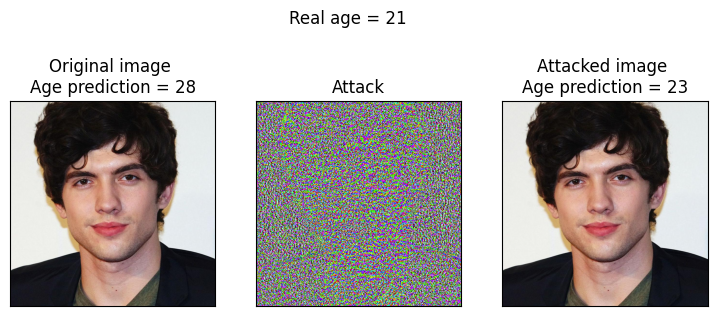

In [88]:
attack = ImageAttacked(model = model, epsilon = 0.1)
# Compute the attack on a image and apply the attack on the same image
image_attacked = attack.apply_attack_to_image("test", "005616.jpg_face.jpg", show=True)

/Users/yoriknyssen/.pyenv/versions/3.10.6/envs/ENSAE/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


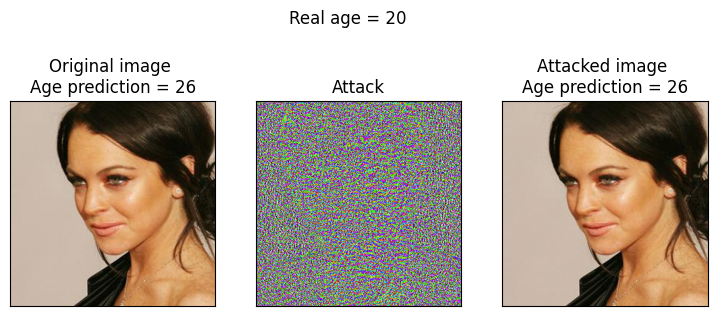

In [90]:
# Apply the same attack (resized) to another image
image_attacked_2 = attack.apply_attack_to_image("test", "007611.jpg_face.jpg", show=True)

## 3. Create attack transformation class for the data loader

In [91]:
class WhiteBoxTransformation():
    """ 
      This class computes and applies a white box attack on any image given as an input.
      The idea is to alter the image until the age prediction becomes bad enough.
      
    Parameters : 
        - model (object) : the pretrained model on which we will apply the white box attack
        - epsilon (float) : the maximum pixel perturbation allowed per step
        - min_age_diff (int) : the minimum difference between the age prediction of the original image and
                               the age prediction of attackedimage
    """
    def __init__(self, model, epsilon : float, min_age_diff : int):
        self.model = model 
        self.espsilon = epsilon
        self.min_age_diff = min_age_diff
        
    def compute_apply_white_box_attack(self, image_tensor, real_age, show = False) : 
        """
            This function computes the white box attack (based on the slef.model) on a image by 
            doing a gradient ascent. 
    
            Parameters : 
                - image_tensor (tensor) : the image on which the attack will be computed and then applied
                - real_age (integer) : the real age of the person (from 0 to 101)
                - show (bool) : displays the original image, the attack and the attacked image if set to True
        """

        # Get the prediction of the model on the original image
        original_prediction = self.model(image_tensor).argmax()
        
        # Create a copy of the original image to attack it and keep the original one for comparaison (visualisation)
        attacked_img_tensor = image_tensor.detach().clone()

        # Enables the grandient computation on the image itself
        attacked_img_tensor.requires_grad = True

        # ---------------------------- LOOP ------------------------------
        # Loop until the difference between the predicted age on the attacked image and 
        # the original age prediction becomes greater then self.min_age_diff
        
        step = 1
        while True : 
            
            # Display the step during computaion
            print(f'Step {step}', end='\r')
            step += 1
            
            # Get the probability for each of the 101 classes computed by the model 
            output = self.model(attacked_img_tensor)

            # Compute the cross entropy loss
            loss = - torch.nn.functional.cross_entropy(output, torch.LongTensor([real_age]))
            
            self.model.zero_grad()

            # Calculate gradients of model in backward pass
            loss.backward()

            # Collect gradient of the image
            grad = attacked_img_tensor.grad.data

            # Compute the attack
            attack = self.espsilon * grad.sign()
            
            # Apply the attack to the original image
            attacked_img_tensor = attacked_img_tensor + attack
            
            # Get the prediction of the model on the attacked image
            attacked_prediction = self.model(attacked_img_tensor).argmax()
            
            # Recreate a copy of the image attacked to reset the .requires_grad to True for the next step
            attacked_img_tensor = attacked_img_tensor.detach().clone() 
            attacked_img_tensor.requires_grad = True
            
            if self.min_age_diff <= abs(attacked_prediction - original_prediction):
                break 
        
        if show : 
            fig , axes = plt.subplots(1,3, figsize = (9,4))
            
            # Display origian image
            axes[0].imshow((image_tensor/255).squeeze().permute(1,2,0).detach().numpy())
            axes[0].set_title(f"Original image \nAge prediction = {original_prediction}")
            axes[0].set_xticks([])
            axes[0].set_yticks([])
            # Display attack
            axes[1].imshow(((image_tensor-attacked_img_tensor)*255).squeeze().permute(1,2,0).detach().numpy(), cmap= 'grey')
            axes[1].set_title("Attack")
            axes[1].set_xticks([])
            axes[1].set_yticks([])
            # Display image attacked 
            axes[2].imshow((attacked_img_tensor/255).squeeze().permute(1,2,0).detach().numpy())
            axes[2].set_xticks([])
            axes[2].set_yticks([])
            axes[2].set_title(f"Attacked image \nAge prediction = {attacked_prediction}")
            
            # Display the real age 
            fig.suptitle(f"Real age = {real_age}")
            
        return attacked_img_tensor
      

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


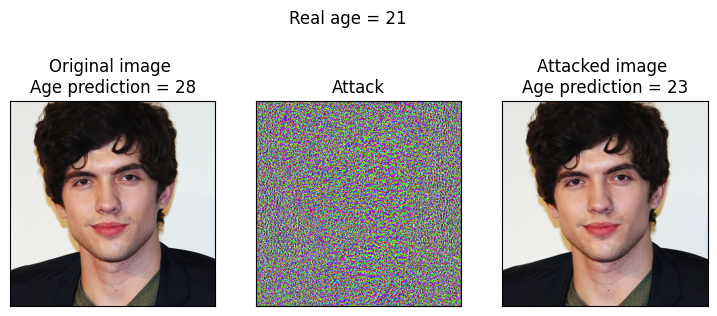

In [92]:
whithe_box_transformation = WhiteBoxTransformation(model = model, epsilon= 0.1, min_age_diff = 0)
attacked_image = whithe_box_transformation.compute_apply_white_box_attack(image_test_tensor, real_age=21, show = True)

# TO DO : 
1.  faire une montée de gradient (en déduirre une transformation) : une image test vs toutes les images test avec transformation spécifique => DONE
1.  modidifier toutes les images si on calcule qu'une seule attaque (sur une seule image)
2. tester le modèle avec ces images attaquées et voir si MEA à augmenter
3. attaquer tous les images train et ré-entraîner le modèle sur Onixia (avec du gros GPU sa mère)
4. retester sur les images test que l'on avait et celle qui ne le sont pas pour voir si 